## GAN Lab Assignment 3

*Name: Madhusudan Hasbe\
PRN: 22070126061\
AIML A3*

-----------

# Implementation of Deep Convolutional Generative Adversarial Networks (DCGAN)

### **Objective**:
The objective of this experiment is to implement and train a Deep Convolutional Generative Adversarial Network (DCGAN) to generate realistic images from the CelebA Faces dataset. The implementation follows the architecture proposed by Radford et al. (2015) in their paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks."

### **Theory**:
DCGANs are a specialized form of GANs that incorporate convolutional neural networks (CNNs) instead of fully connected layers to improve image generation. The key modifications introduced by Radford et al. include:
- Use of strided convolutions and transposed convolutions instead of pooling layers for better feature learning.
- Batch normalization to stabilize training and prevent mode collapse.
- Leaky ReLU activation in the discriminator and ReLU activation in the generator, ensuring better gradient flow.
- Tanh activation function in the final layer of the generator to normalize output images.


### **Dataset Description**:
CelebA (Large-scale CelebFaces Attributes Dataset): Contains over 200,000 celebrity face images with diverse backgrounds and attributes, making it ideal for training facial image generators.

--------------------

In [ ]:
# Import necessary libraries
import torch  # PyTorch library for tensor computations and deep learning
import torch.nn as nn  # Module to define neural network layers
import torch.optim as optim  # Optimizer module for training neural networks
from torch.utils.data import DataLoader  # Utility for efficient data loading
from torchvision import datasets, transforms  # Utilities for handling image datasets and transformations
from torchvision.utils import save_image  # Function to save generated images
import kagglehub  # Library to download datasets from Kaggle
import os  # Provides functions for interacting with the operating system
from IPython.display import Image, display  # Allows displaying images in Jupyter Notebook
import glob  # Enables searching for files matching specific patterns

In [ ]:
# Set the device to GPU if available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the selected device (useful for debugging and ensuring the correct hardware is used)
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Hyperparameters for training the DCGAN

batch_size = 128  # Number of images per batch during training
image_size = 64   # Size (height & width) of input images (assumed square)
nz = 100  # Size of the latent vector (random noise input for the generator)
num_epochs = 10  # Number of times the model sees the entire dataset
lr = 0.0001  # Learning rate for the optimizer (controls step size in gradient updates)
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer (controls momentum term)

In [ ]:
# Download and load the CelebA dataset using KaggleHub

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")  # Downloads the dataset and returns the local path
print("Path to dataset files:", path)  # Prints the location where the dataset is stored

100%|██████████| 1.33G/1.33G [00:11<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [ ]:
# Define image transformations to preprocess the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to the specified size (64x64)
    transforms.CenterCrop(image_size),  # Crop the center of the image to match the required size
    transforms.ToTensor(),  # Convert image to a PyTorch tensor (values in range [0,1])
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values to range [-1,1] for better GAN training
])

# Load the dataset from the downloaded path
dataset = datasets.ImageFolder(root=path, transform=transform)  # Load images and apply transformations

# Create a DataLoader to efficiently handle batches of images
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Shuffle images to add randomness during training

In [ ]:
# Define the Generator class for DCGAN
class Generator(nn.Module):
    def __init__(self, nz):
        """
        Generator network that takes a latent vector (random noise) as input
        and generates a synthetic image using transposed convolutional layers.

        Args:
        nz (int): Size of the latent vector (input noise dimension).
        """
        super(Generator, self).__init__()

        # Define the main sequential model for the generator
        self.main = nn.Sequential(
            # First transposed convolution layer: (nz x 1 x 1) -> (512 x 4 x 4)
            nn.ConvTranspose2d(nz, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),  # Normalize feature maps to stabilize training
            nn.ReLU(True),  # Apply ReLU activation for non-linearity

            # Second transposed convolution: (512 x 4 x 4) -> (256 x 8 x 8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # Third transposed convolution: (256 x 8 x 8) -> (128 x 16 x 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Fourth transposed convolution: (128 x 16 x 16) -> (64 x 32 x 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Output layer: (64 x 32 x 32) -> (3 x 64 x 64)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Apply Tanh activation to scale output pixels to [-1, 1]
        )

    def forward(self, input):
        """
        Forward pass of the generator.

        Args:
        input (tensor): Random noise vector of shape (batch_size, nz, 1, 1).

        Returns:
        tensor: Generated image of shape (batch_size, 3, 64, 64).
        """
        return self.main(input)

In [ ]:
# Define the Discriminator class for DCGAN
class Discriminator(nn.Module):
    def __init__(self):
        """
        Discriminator network that takes an image as input and determines
        whether it is real or fake using a series of convolutional layers.
        """
        super(Discriminator, self).__init__()

        # Define the main sequential model for the discriminator
        self.main = nn.Sequential(
            # First convolutional layer: (3 x 64 x 64) -> (64 x 32 x 32)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation to allow small negative gradients

            # Second convolutional layer: (64 x 32 x 32) -> (128 x 16 x 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),  # Normalize feature maps to stabilize training
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer: (128 x 16 x 16) -> (256 x 8 x 8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth convolutional layer: (256 x 8 x 8) -> (512 x 4 x 4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer: (512 x 4 x 4) -> (1 x 1 x 1)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Apply Sigmoid activation to output a probability (0 = fake, 1 = real)
        )

    def forward(self, input):
        """
        Forward pass of the discriminator.

        Args:
        input (tensor): Image tensor of shape (batch_size, 3, 64, 64).

        Returns:
        tensor: Probability (between 0 and 1) indicating whether the image is real or fake.
        """
        return self.main(input)

In [ ]:
# Initialize the Generator and Discriminator models

netG = Generator(nz).to(device)  # Create an instance of the Generator and move it to the selected device (CPU/GPU)
netD = Discriminator().to(device)  # Create an instance of the Discriminator and move it to the selected device

In [ ]:
# Define the loss function and optimizers

criterion = nn.BCELoss()  # Binary Cross Entropy Loss for real/fake classification

# Optimizer for the Discriminator
optimizerD = optim.Adam(
    netD.parameters(),  # Parameters of the Discriminator
    lr=lr * 0.5,  # Learning rate (half of Generator's to stabilize training)
    betas=(beta1, 0.999)  # Adam optimizer hyperparameters for momentum
)

# Optimizer for the Generator
optimizerG = optim.Adam(
    netG.parameters(),  # Parameters of the Generator
    lr=lr,  # Learning rate
    betas=(beta1, 0.999)  # Adam optimizer hyperparameters
)

In [ ]:
# Training loop
for epoch in range(num_epochs):  # Loop through the number of epochs
    for i, data in enumerate(dataloader, 0):  # Iterate through batches of images

        # -------------------------------
        # Update Discriminator (netD)
        # -------------------------------
        netD.zero_grad()  # Zero the gradients to prevent accumulation

        # Train with real images
        real_cpu = data[0].to(device)  # Get real images from the dataset
        batch_size = real_cpu.size(0)  # Get the batch size
        label = torch.full((batch_size,), 0.9, dtype=torch.float, device=device)
        # Create labels for real images (soft label smoothing: 0.9 instead of 1)

        output = netD(real_cpu).view(-1)  # Forward pass through the Discriminator
        errD_real = criterion(output, label)  # Compute loss on real images
        errD_real.backward()  # Backpropagate the error
        D_x = output.mean().item()  # Track real image confidence

        # Train with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)  # Generate random noise
        fake = netG(noise)  # Generate fake images using the Generator
        label.fill_(0.1)  # Assign fake labels (soft label smoothing: 0.1 instead of 0)

        output = netD(fake.detach()).view(-1)  # Discriminator evaluates fake images (detach to avoid updating Generator)
        errD_fake = criterion(output, label)  # Compute loss on fake images
        errD_fake.backward()  # Backpropagate the error
        D_G_z1 = output.mean().item()  # Track fake image confidence

        errD = errD_real + errD_fake  # Total Discriminator loss
        optimizerD.step()  # Update Discriminator weights

        # -------------------------------
        # Update Generator (netG)
        # -------------------------------
        netG.zero_grad()  # Zero the gradients

        label.fill_(0.9)  # Generator wants the fake images to be classified as real (label = 0.9)

        output = netD(fake).view(-1)  # Get discriminator's prediction on fake images
        errG = criterion(output, label)  # Compute Generator loss (wants to fool Discriminator)
        errG.backward()  # Backpropagate the error
        D_G_z2 = output.mean().item()  # Track Generator performance
        optimizerG.step()  # Update Generator weights

        # -------------------------------
        # Print Training Stats
        # -------------------------------
        if i % 50 == 0:  # Print every 50 batches
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # -------------------------------
    # Save Real & Fake Images Every 2 Epochs
    # -------------------------------
    if epoch % 2 == 0:
        save_image(fake.detach().cpu()[:64], f'fake_samples_epoch_{epoch}.png', normalize=True)
        # Save generated images from this epoch

        save_image(real_cpu.detach().cpu()[:64], f'real_samples_epoch_{epoch}.png', normalize=True)
        # Save real images from this epoch

[0/10][0/1583] Loss_D: 1.4349 Loss_G: 0.9913 D(x): 0.5427 D(G(z)): 0.5457 / 0.3586
[0/10][50/1583] Loss_D: 0.7680 Loss_G: 3.2873 D(x): 0.8332 D(G(z)): 0.1774 / 0.0275
[0/10][100/1583] Loss_D: 0.6976 Loss_G: 3.4549 D(x): 0.8598 D(G(z)): 0.1488 / 0.0224
[0/10][150/1583] Loss_D: 0.6977 Loss_G: 2.8768 D(x): 0.8496 D(G(z)): 0.0892 / 0.0418
[0/10][200/1583] Loss_D: 0.7318 Loss_G: 3.5214 D(x): 0.8421 D(G(z)): 0.2036 / 0.0203
[0/10][250/1583] Loss_D: 0.6918 Loss_G: 3.4614 D(x): 0.8778 D(G(z)): 0.1733 / 0.0216
[0/10][300/1583] Loss_D: 0.6968 Loss_G: 2.5877 D(x): 0.8339 D(G(z)): 0.1325 / 0.0577
[0/10][350/1583] Loss_D: 0.6738 Loss_G: 2.5576 D(x): 0.8618 D(G(z)): 0.1060 / 0.0597
[0/10][400/1583] Loss_D: 0.7834 Loss_G: 3.3969 D(x): 0.9215 D(G(z)): 0.2958 / 0.0232
[0/10][450/1583] Loss_D: 0.6947 Loss_G: 2.3087 D(x): 0.8487 D(G(z)): 0.1331 / 0.0806
[0/10][500/1583] Loss_D: 0.7384 Loss_G: 1.8932 D(x): 0.8121 D(G(z)): 0.1269 / 0.1286
[0/10][550/1583] Loss_D: 0.9481 Loss_G: 1.4045 D(x): 0.5988 D(G(z)):

Epoch: 0
Real Images:


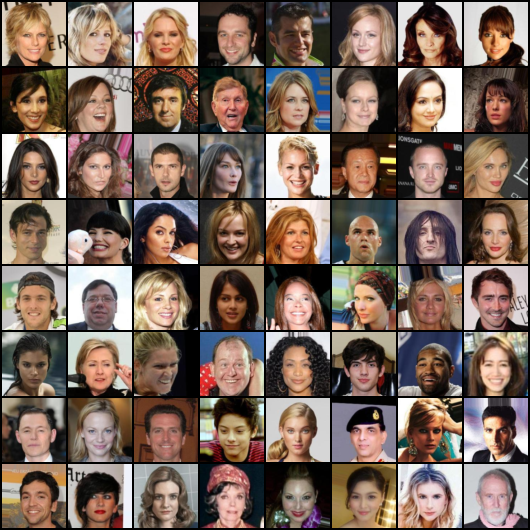

Fake Images:


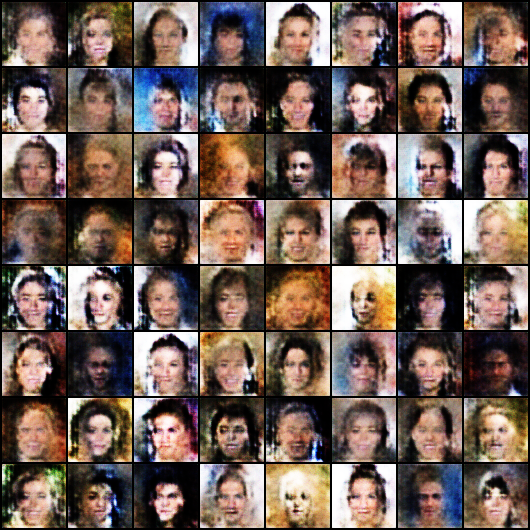

Epoch: 2
Real Images:


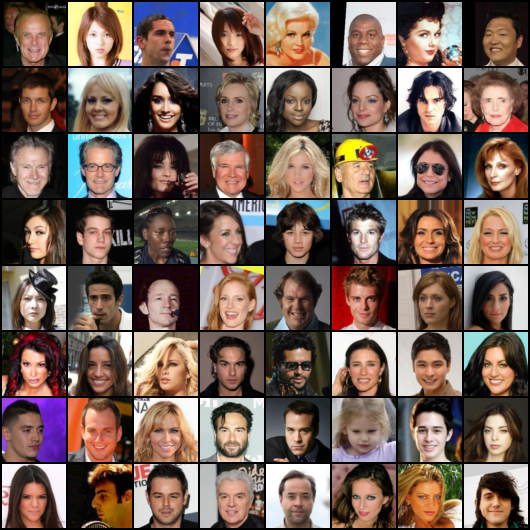

Fake Images:


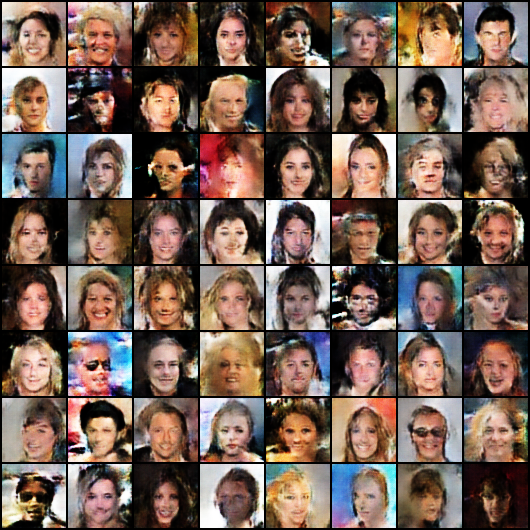

Epoch: 4
Real Images:


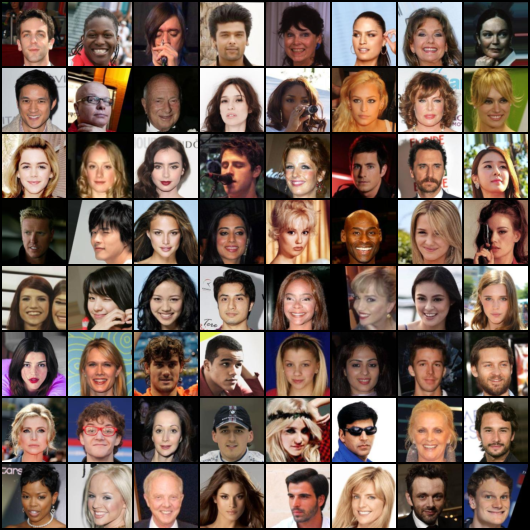

Fake Images:


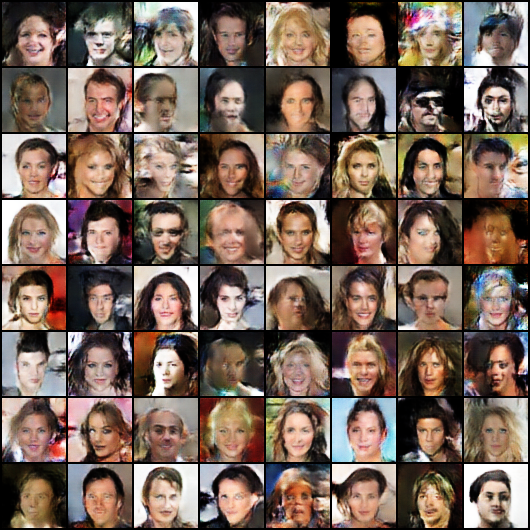

Epoch: 6
Real Images:


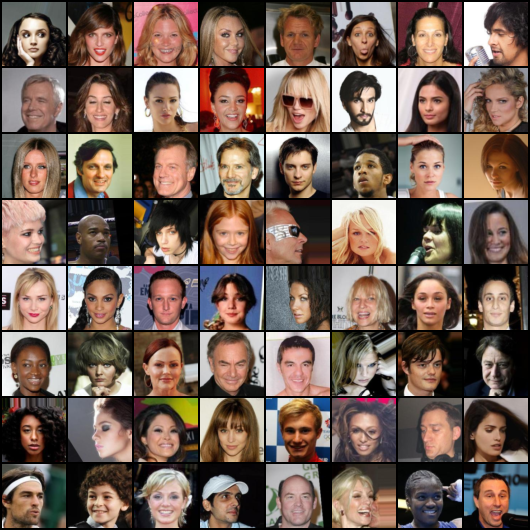

Fake Images:


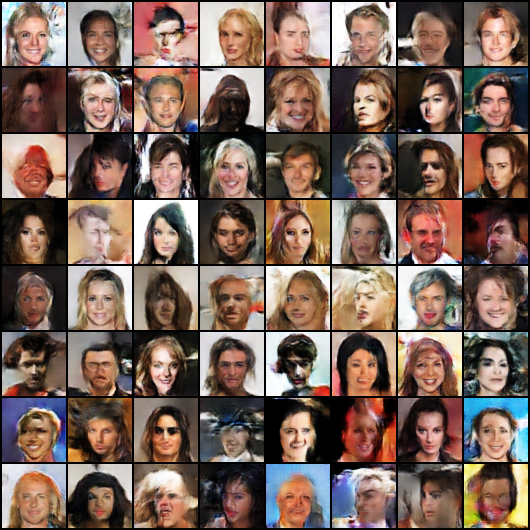

Epoch: 8
Real Images:


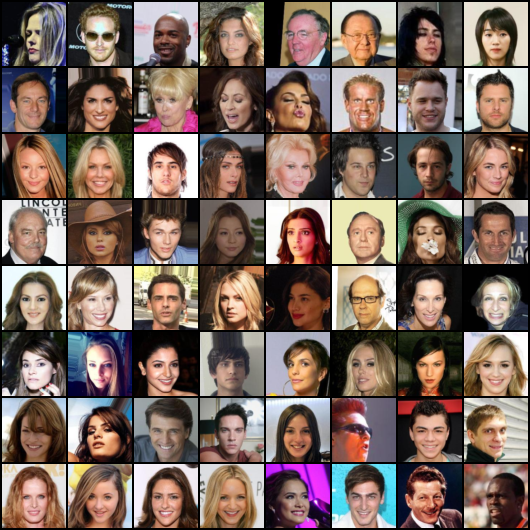

Fake Images:


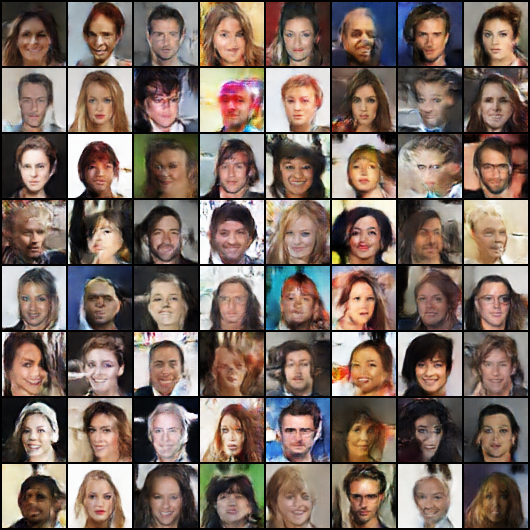

In [ ]:
# Retrieve all saved real and fake image files
real_images = sorted(glob.glob("real_samples_epoch_*.png"), key=os.path.getctime)
# Get all files matching "real_samples_epoch_*.png" and sort them by creation time

fake_images = sorted(glob.glob("fake_samples_epoch_*.png"), key=os.path.getctime)
# Get all files matching "fake_samples_epoch_*.png" and sort them by creation time

# Iterate through paired real and fake images for each saved epoch
for real, fake in zip(real_images, fake_images):
    epoch_number = real.split('_')[-1].split('.')[0]  # Extract epoch number from filename
    print(f"Epoch: {epoch_number}")  # Display the epoch number

    # Display real images
    print("Real Images:")
    display(Image(real))

    # Display fake images
    print("Fake Images:")
    display(Image(fake))

----------------

### **References**:
1. https://arxiv.org/pdf/1511.06434
2. https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py
3. https://github.com/GRajaraju/CV/blob/master/DCGAN.py
4. https://github.com/jorcus/Computer-Vision-A-Z/blob/master/Module-3-GANs/dcgan.py
5. https://github.com/amyzhao11/GANBrain/blob/main/modelscript.py
6. ChatGPT